# Машинное обучение, ФКН ВШЭ

# Семинар 7

## Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

 Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [24]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [25]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

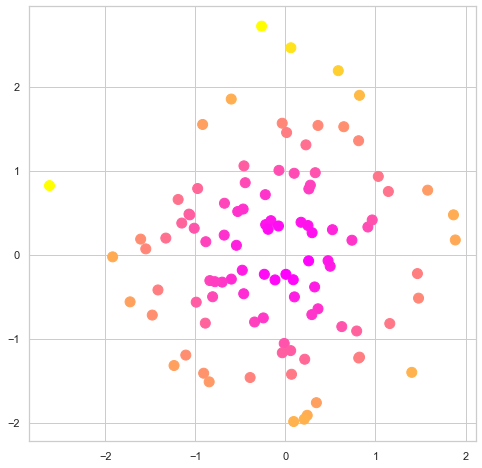

In [26]:
np.random.seed(42)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [27]:
from sklearn.tree import DecisionTreeRegressor

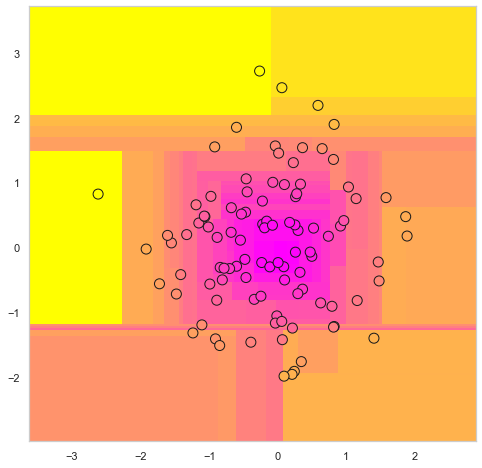

In [28]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

In [32]:
predicted.shape

(671, 651)

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

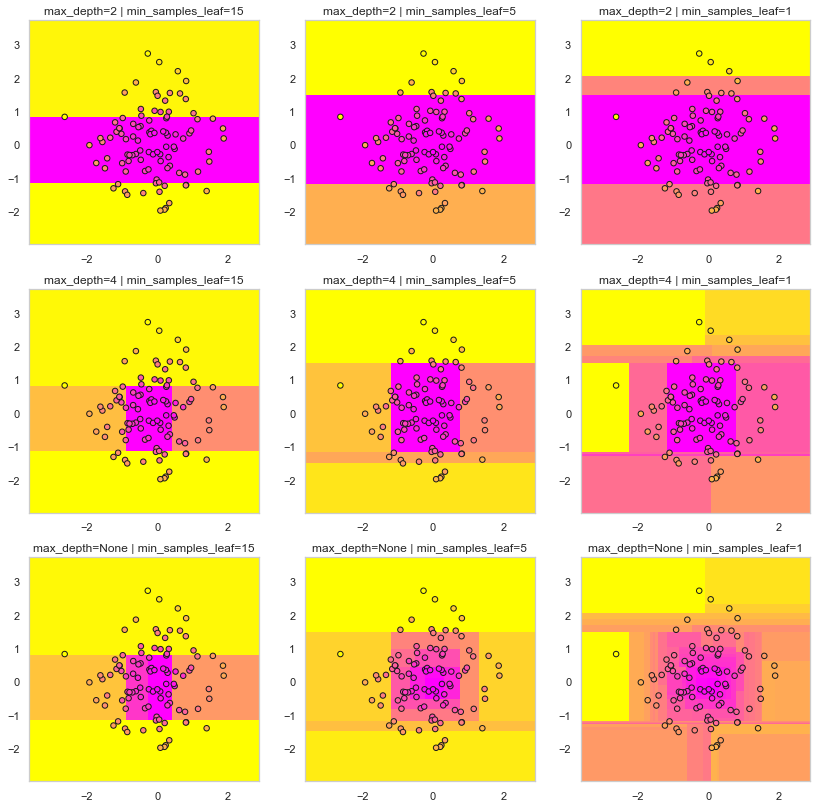

In [6]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


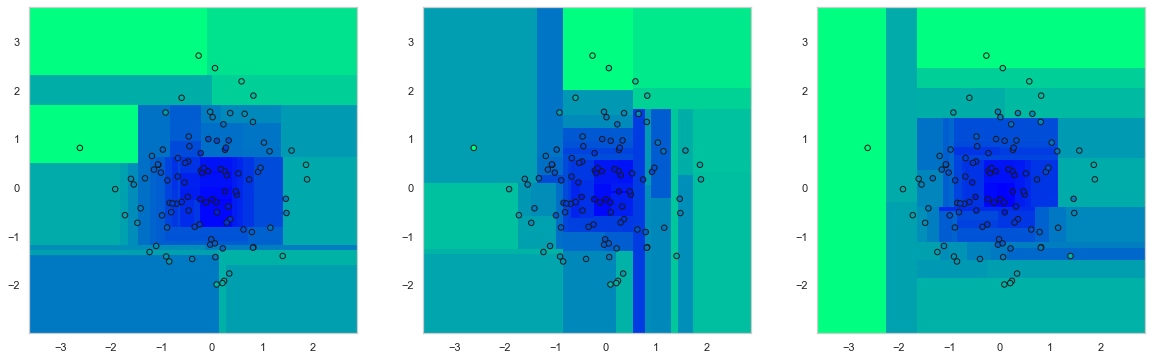

In [8]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных &mdash; Бостонском датасете.

Загрузим датасет и посмотрим на него.

In [9]:
from sklearn.datasets import load_boston

data = load_boston()
X = data.data
y = data.target

Сделаем разбиения для кросс-валидации

In [10]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=241)

Обучим обычное дерево

In [14]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
-cross_val_score(regr, X, y, cv=cv, 
                 scoring='neg_mean_squared_error').mean()

29.252426713259563

In [15]:
regr.fit(X, y)
regr.tree_

In [16]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
cross_val_score(regr, X, y, cv=cv, 
                scoring='r2').mean()

0.63896748450608

Теперь переберем разные параметры для дерева

In [17]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'], # the number of features to consider when looking for the best split
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=241),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 4, 8, 32]},
             scoring='r2')

In [18]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']

In [19]:
cv_grid.head()

,max_depth,max_features,min_samples_leaf,mean_test_score
0,2,auto,1,0.628959
1,2,auto,4,0.628959
2,2,auto,8,0.628959
3,2,auto,32,0.592873
4,2,log2,1,0.405284


In [20]:
cv_grid.sort_values('mean_test_score')

,max_depth,max_features,min_samples_leaf,mean_test_score
9,2,sqrt,4,0.405284
4,2,log2,1,0.405284
5,2,log2,4,0.405284
6,2,log2,8,0.405284
8,2,sqrt,1,0.405284
...,...,...,...,...
61,20,auto,4,0.755512
73,50,auto,4,0.755512
37,8,auto,4,0.755958
26,6,auto,8,0.756028


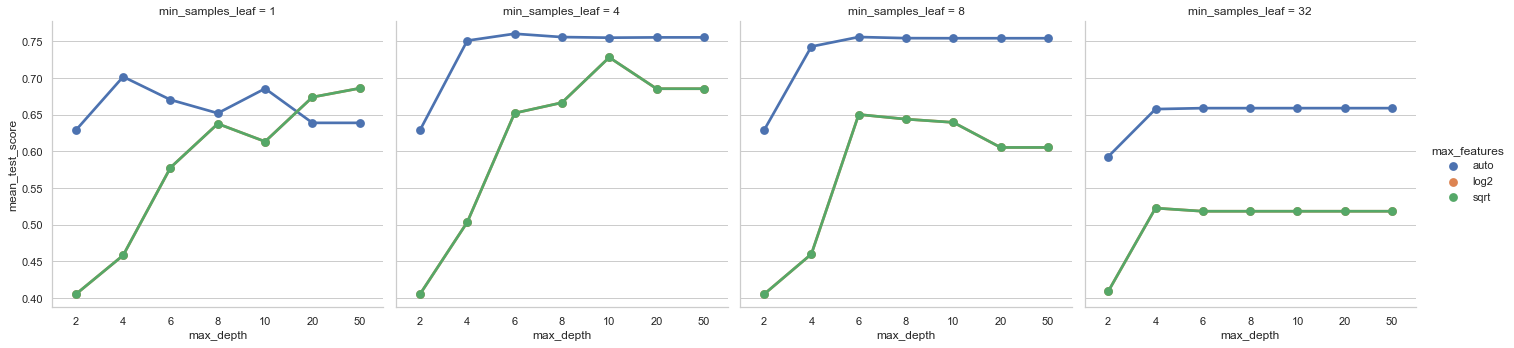

In [21]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

* предположите почему при увеличении параметра `min_samples_leaf` дерево перестает переобучаться при росте `max_depth` ?

In [22]:
gs.best_score_

0.7604838117717478

In [23]:
gs.best_params_

{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4}

## Oblivious Decision Tree

![](https://qph.fs.quoracdn.net/main-qimg-5274e48e1766230e22e3cdd7e83019ce)

* Один предикат вида $[x_j < t]$ для каждого уровня.
* Слабее обычных деревьев, препятствуют переобучению.
* Гораздо эффективнее произвольных деревьев.
* Достаточно хранить последовательность порогов и номеров признаков.
* Каждому листу можно сопоставить уникальную последовательность 0 и 1, которое соответствует натуральному числу (индекс). Можно хранить листья как массив и обращать к ним по индексу.

![](https://qph.fs.quoracdn.net/main-qimg-c8457d5d20273f0368f801d6593aa667)

## Multivariate Adaptive Regression Splines Model (MARS)

$$ f(x) = \sum_{i=1}^M w_i B_i(x) $$
$$ B_i(x) = \prod_{j=1}^{m_i} \left[ \alpha_{ij} (t_{ij} - x)_+ + \beta_{ij} (x - t_{ij})_+ \right]$$

где $(t_{ij} - x)_+ = \max(0, t_{ij} - x)$ &mdash; hinge функция:




![](https://upload.wikimedia.org/wikipedia/commons/7/74/Friedmans_mars_hinge_functions.png)

__При чем тут деревья?__

* Вспомним что предсказание дерева $a(x)$ можно выразить как:
$$ a(x) = \sum_{i=1}^M w_i [x \in J_i] = \sum_{i=1}^M w_i \prod _{j=1}^{m_i}\left( \alpha_{ij} [x < t_{ij}] + \beta_{ij} [x \geq t_{ij}] \right),$$
где $\alpha_{ij}, \beta_{ij} \in \{0, 1\}$ и $\alpha_{ij} \cdot \beta_{ij} = 0$, $m_i$ &mdash; глубина дерева до листа $J_i$.

* Можно заметить, что дерево имеет похожую на MARS структуру, только с индикатарами вместо hindge функции.
* Обучаются такие модели тоже жадными алгоритмами.

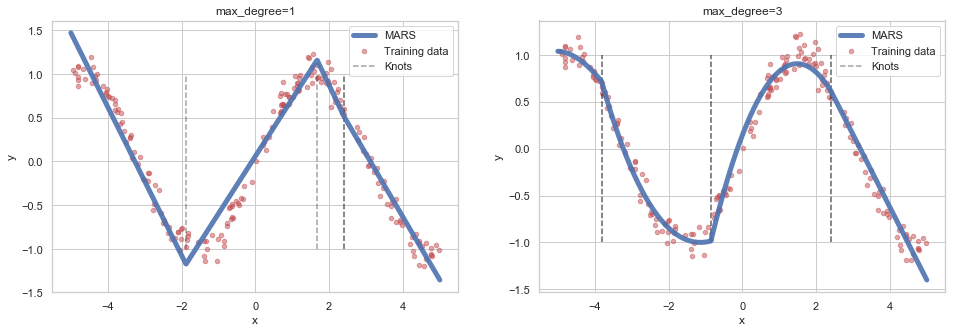

In [23]:
import numpy
from pyearth import Earth
    
#Create some fake data
def f(x):
    return x ** 2
numpy.random.seed(0)
m = 200
n = 10
X = 10 * (numpy.random.uniform(size=(m,1)) - 0.5)
y = np.sin(X[:, 0]) + .1*numpy.random.normal(size=m)
test = np.linspace(-5, 5, 1000)[:, np.newaxis]
y_test = np.sin(test[:, 0])
#Fit an Earth model
# plt.subplot(1, 2, 1)

plt.figure(figsize=(16, 5))

for i, degree in enumerate([1, 3]):
    plt.subplot(1, 2, i + 1)
    model = Earth(max_terms=5, max_degree=degree)
    model.fit(X,y)

    y_hat = model.predict(test)
    knots = list(map(lambda x: x.get_knot(), list(model.basis_.piter())[1:]))

    plt.scatter(X, y, s=20, c='r', alpha=.5, label='Training data')
    plt.plot(test, y_hat, lw=5, alpha=.9, label='MARS')
    plt.vlines(knots, -1, 1, linestyles='--', alpha=.4, label='Knots')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('max_degree=%d'%degree)
    plt.legend()

In [24]:
print(model.summary())

Earth Model
-------------------------------------------------------------------
Basis Function                                Pruned  Coefficient  
-------------------------------------------------------------------
(Intercept)                                   No      0.618697     
h(x0-2.39551)                                 No      -0.77481     
h(2.39551-x0)                                 No      -0.493397    
h(x0+0.853381)*h(2.39551-x0)                  No      0.345539     
h(-0.853381-x0)*h(2.39551-x0)                 No      0.171971     
h(x0+3.81726)*h(-0.853381-x0)*h(2.39551-x0)   No      -0.0176479   
h(-3.81726-x0)*h(-0.853381-x0)*h(2.39551-x0)  No      -0.0332385   
-------------------------------------------------------------------
MSE: 0.0157, GCV: 0.0186, RSQ: 0.9724, GRSQ: 0.9677


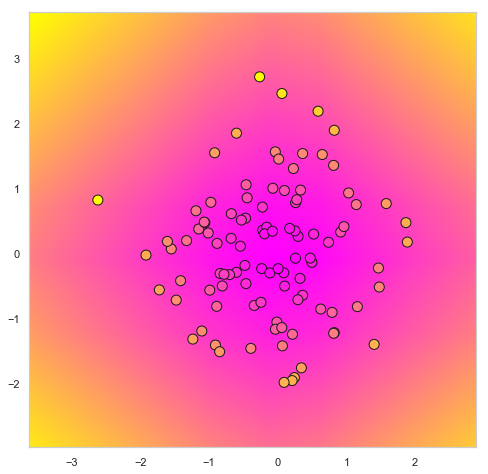

In [25]:
clf = Earth()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Сравним с обычными деревьями на BostonHausing

In [26]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score


data = load_boston()
X = data.data
y = data.target
cv = KFold(shuffle=True, random_state=241)

In [27]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(Earth(),
                  param_grid={
                      'max_degree': [1, 2, 3],
                      'max_terms': [5, 10, 15, 20],
                      'penalty': np.logspace(-4, 0, 5),
                  },
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=241, shuffle=True),
       error_score='raise',
       estimator=Earth(allow_linear=None, allow_missing=False, check_every=None,
   enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
   fast_h=None, feature_importance_type=None, max_degree=None,
   max_terms=None, min_search_points=None, minspan=None,
   minspan_alpha=None, penalty=None, smooth=None, thresh=None,
   use_fast=None, verbose=0, zero_tol=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_degree': [1, 2, 3], 'max_terms': [5, 10, 15, 20], 'penalty': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [28]:
gs.best_score_

0.8313819329702372

In [29]:
gs.best_params_

{'max_degree': 2, 'max_terms': 20, 'penalty': 0.0001}